In [52]:
import os
import tarfile
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, impute, preprocessing
%matplotlib inline

## Get data

In [19]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [20]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [21]:
fetch_housing_data()

In [22]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [23]:
housing = load_housing_data()

In [24]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [25]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [26]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [27]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


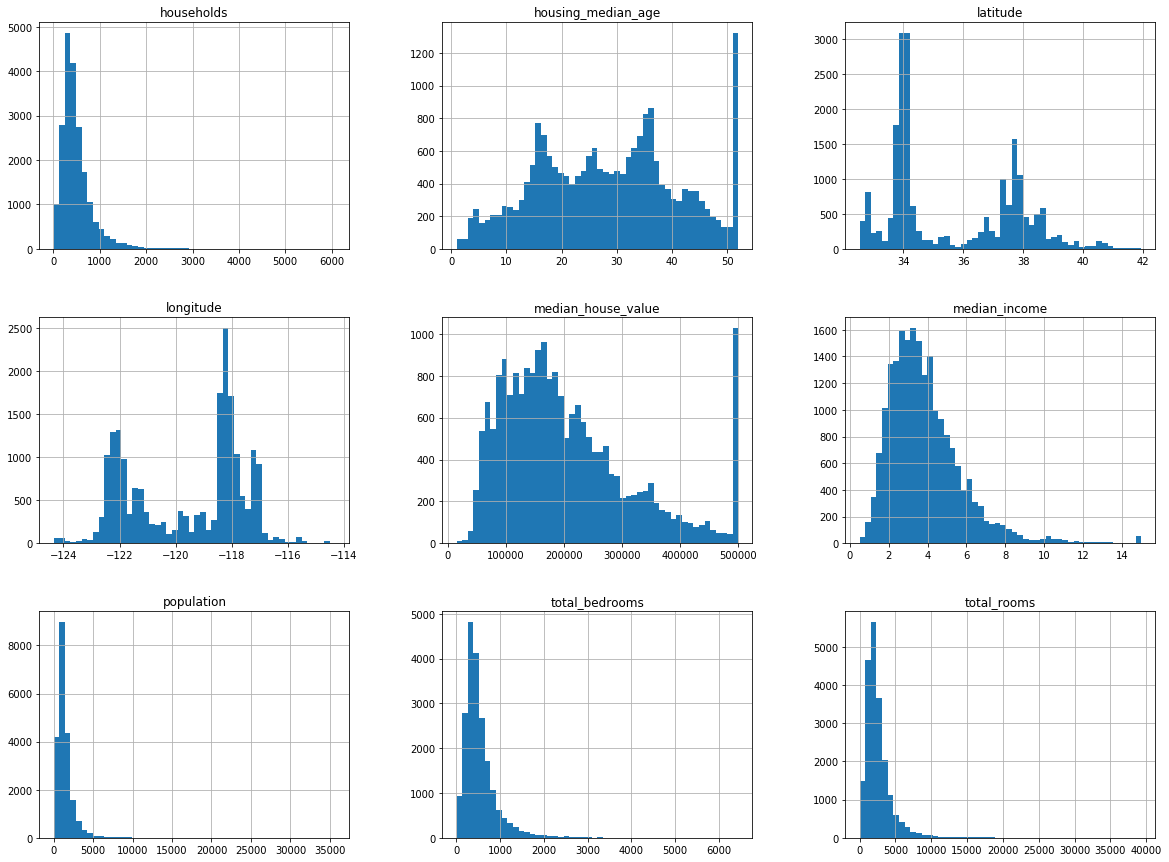

In [28]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

## Construct test set

In [29]:
# Create a test set NOW to prevent
# your brain, as well as any model, 
# from overfitting!!! (ie data snooping)

# Here are some various ways to implement
# a train/test splitting function

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [30]:
train_set, test_set = split_train_test(housing, 0.2)

In [31]:
# Implementation of a test-splitting function
# that allows the dataset to be updated yet
# consistently pick the same instances for
# the test set:

from zlib import crc32

def test_set_check(identifier, test_ratio):
    thing = crc32( np.int64(identifier) & 0xffffffff)
    other_thing = test_ratio * 2 ** 32
    is_test = thing < other_thing
    return is_test

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [32]:
housing_w_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_w_id, 0.2, "index")

In [33]:
# Using sklearn
train_set, test_set = model_selection.train_test_split(housing,
                                                       test_size=0.2,
                                                       random_state=42)

In [34]:
# Suppose we need to do stratified sampling to
# prevent errors from sampling bias in the test set:

bins = [0, 1.5, 3.0, 4.5, 6, np.inf]
labels = range(1, len(bins))  # 1-based labels
housing["income_cat"] = pd.cut(housing["median_income"], bins=bins, labels=labels)

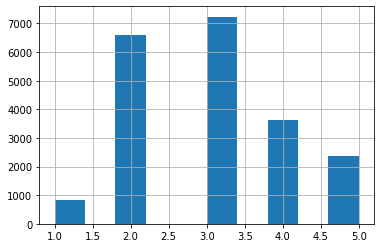

In [35]:
housing["income_cat"].hist()

In [36]:
# Now use sklearn to do a stratified split
kwargs = {
    "n_splits": 1,
    "test_size": 0.2,
    "random_state": 42
}
split = model_selection.StratifiedShuffleSplit(**kwargs)

In [37]:
gen = split.split(housing, housing["income_cat"])
for train_ix, test_ix in gen:
    strat_train_set = housing.loc[train_ix]
    strat_test_set = housing.loc[test_ix]

In [38]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [39]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Visualize data

In [46]:
# Training set is small enough to be used for EDA.
# Can always just take a smaller sample if that's
# not the case.
housing = train_set.copy()

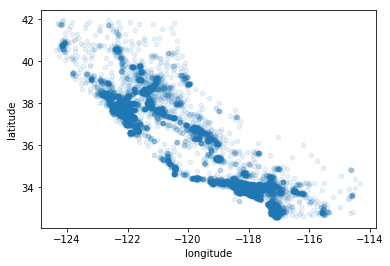

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

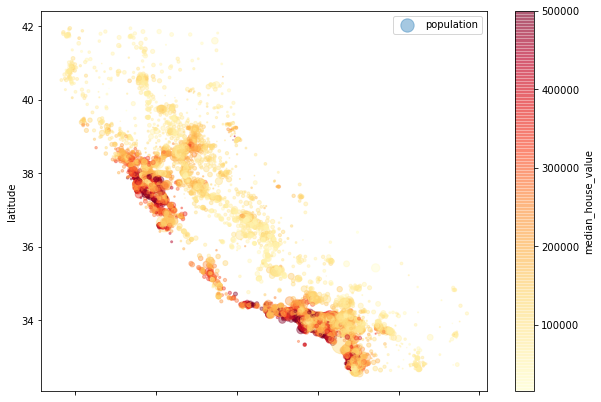

In [35]:
kwargs = {
    "kind": "scatter",
    "x": "longitude",
    "y": "latitude",
    "alpha": 0.4,
    "s": housing["population"] / 100,
    "label": "population",
    "figsize": (10, 7),
    "c": "median_house_value",
    "cmap": plt.get_cmap("YlOrRd"),
    "colorbar": True
}
housing.plot(**kwargs)
plt.legend();

In [36]:
# Pearson's r -- correlation btwn each pair of attributes
corr_matrix = housing.corr()

In [37]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

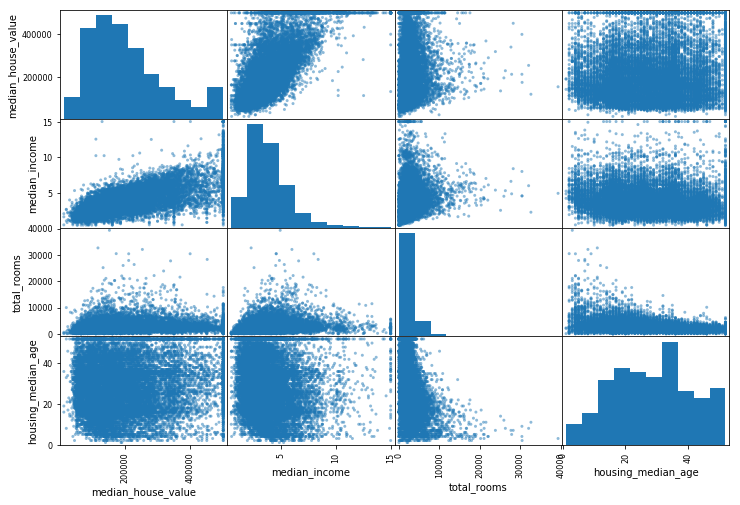

In [39]:
# Another way to check the correlation between attributes
attrs = ["median_house_value", "median_income", "total_rooms", 
         "housing_median_age"]
pd.plotting.scatter_matrix(housing[attrs], figsize=(12, 8));

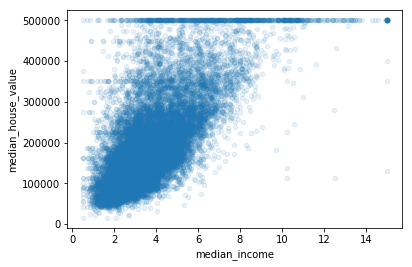

In [41]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

## Engineer some new features

In [47]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [48]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

## Prepare data for model

In [40]:
# Copy fresh
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

In [ ]:
# Some options to deal with missing values
housing.dropna(subset=["total_bedrooms"])  # Drop rows
housing.drop("total_bedrooms", axis=1)     # Drop column
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)   # Fill with value (median)

In [41]:
# Using sklearn
# SimpleImputer doesn't take nonnumeric features
imputer = impute.SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [43]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [44]:
housing.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [47]:
# Use "trained" imputer to "transform" the data
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)

In [54]:
# Categorical attributes
housing_cat = housing[["ocean_proximity"]]

In [59]:
# Trafo to ordinal
# Output is an np.array
ordinal_encoder = preprocessing.OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [61]:
# Categorical encoding / dummies
# Output is a scipy sparse matrix
cat_encoder = preprocessing.OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>